### Loading dataset

In [153]:
# Basic Statistics
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



file_name = '../measurements.csv'
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".")
df['Language'].replace('CSharp', 'C#', inplace=True)
df.head()

/tmp/ipykernel_14111/3309331759.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Language'].replace('CSharp', 'C#', inplace=True)


,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,Ada,binary-trees,-1,111.164307,83.531372,0.000000,10.218201,2930.0,30.2,202916
1,Ada,binary-trees,-1,104.618347,78.319946,0.000000,9.582825,2786.0,30.2,202912
2,Ada,binary-trees,-1,103.557495,76.979980,0.000854,9.681396,2815.0,31.2,203216
3,Ada,binary-trees,-1,105.154663,79.431458,0.000000,9.418457,2731.0,32.5,203136
4,Ada,binary-trees,-1,104.885132,78.551208,0.000000,9.657104,2784.0,32.2,203208


### Removing "error" entries

In [154]:
df = df[df['Time'] != 'error']

### Cast variables to float

In [155]:
# List of variables to be cast to float
variables_to_cast = ['Package', 'Core', 'GPU', 'DRAM', 'Time', 'Temperature', 'Memory']

# Iterate through the specified variables and cast them to float
for variable in variables_to_cast:
    df[variable] = pd.to_numeric(df[variable], errors='coerce').astype(float)

df['Program'] = df['Program'].str.lstrip()
# Display the modified DataFrame
df.head()


,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,Ada,binary-trees,-1,111.164307,83.531372,0.000000,10.218201,2930.0,30.2,202916.0
1,Ada,binary-trees,-1,104.618347,78.319946,0.000000,9.582825,2786.0,30.2,202912.0
2,Ada,binary-trees,-1,103.557495,76.979980,0.000854,9.681396,2815.0,31.2,203216.0
3,Ada,binary-trees,-1,105.154663,79.431458,0.000000,9.418457,2731.0,32.5,203136.0
4,Ada,binary-trees,-1,104.885132,78.551208,0.000000,9.657104,2784.0,32.2,203208.0


In [156]:
df.dtypes

Language        object
Program         object
PowerLimit       int64
Package        float64
Core           float64
GPU            float64
DRAM           float64
Time           float64
Temperature    float64
Memory         float64
dtype: object

### Dropping irrelevant columns

In [157]:
dfAnalise = df.drop(['GPU', 'Core','DRAM'], axis=1)

In [158]:
dfAnalise.shape[0]

20899

### Removing outliers (3 best and 3 worst)

In [159]:
import pandas as pd

group_columns = ['Language', 'Program', 'PowerLimit']
value_column = 'Package'
n_values_to_remove = 3

# Define a function to remove the lowest and highest values within each group
def remove_extremes(group):
    sorted_group = group.sort_values(value_column)
    condition = (sorted_group["Language"] == "Go") & (sorted_group["Program"] == "spectral-norm") & (sorted_group["PowerLimit"] == 15)
    
    if condition.any():
        # Para o caso específico, remover os 3 piores e os 2 melhores valores
        return sorted_group.iloc[n_values_to_remove:-(2)]
    else:
        # Para os outros casos, remover os 3 piores e 3 melhores valores
        return sorted_group.iloc[n_values_to_remove:-n_values_to_remove]

# Apply the function within each group using groupby with multiple columns
dfAnalise = dfAnalise.groupby(group_columns, group_keys=False, sort=False).apply(remove_extremes)

dfAnalise

/tmp/ipykernel_14111/1125855409.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfAnalise = dfAnalise.groupby(group_columns, group_keys=False, sort=False).apply(remove_extremes)


,Language,Program,PowerLimit,Package,Time,Temperature,Memory
1,Ada,binary-trees,-1,104.618347,2786.0,30.2,202912.0
4,Ada,binary-trees,-1,104.885132,2784.0,32.2,203208.0
7,Ada,binary-trees,-1,104.973206,2787.0,34.0,202772.0
11,Ada,binary-trees,-1,105.053101,2803.0,35.5,202772.0
3,Ada,binary-trees,-1,105.154663,2731.0,32.5,203136.0
...,...,...,...,...,...,...,...
20895,Swift,spectral-norm,25,41.473877,1663.0,40.0,8272.0
20897,Swift,spectral-norm,25,41.481934,1663.0,39.5,8216.0
20894,Swift,spectral-norm,25,41.497986,1663.0,39.2,8428.0
20881,Swift,spectral-norm,25,41.518494,1664.0,39.5,8272.0


#### Number of executions by Language, Program and PowerLimit values

In [160]:
ola= dfAnalise.groupby(['Language', 'Program', 'PowerLimit']).size().reset_index(name='ExecutionCount')
ola[ola["Language"] == "Go"]

,Language,Program,PowerLimit,ExecutionCount
315,Go,binary-trees,-1,14
316,Go,binary-trees,2,14
317,Go,binary-trees,10,14
318,Go,binary-trees,15,14
319,Go,binary-trees,25,14
320,Go,fannkuch-redux,-1,14
321,Go,fannkuch-redux,2,14
322,Go,fannkuch-redux,10,14
323,Go,fannkuch-redux,15,14
324,Go,fannkuch-redux,25,14


In [161]:
dfAnalise.shape[0]

14630

### Removing Lisp and problem pidigits

In [162]:
#Remoção do pidigits e do Lisp (tem uma execução inválida)
dfAnalise = dfAnalise[dfAnalise['Program'] != 'pidigits']
dfAnalise = dfAnalise[dfAnalise['Language'] != 'Lisp']

### Removing F# and Pascal due to insuficient number of implementations of the CLBG problems

In [163]:
languagesProgramImplm = {}
for language, group in dfAnalise.groupby('Language'):
    programs = group['Program'].unique().tolist()
    languagesProgramImplm[language] = programs
for language in languagesProgramImplm:
    print(language, " -> " , languagesProgramImplm[language])

Ada  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C#  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
C++  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
Dart  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
Erlang  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'reverse-complement', 'spectral-norm']
FSharp  ->  ['binary-trees', 'fannkuch-redux', 'fasta', 'k-nucleotide', 'mandelbrot', 'n-body', 'regex-redux', 'spect

In [164]:
for language in languagesProgramImplm:
    languagesProgramImplm[language] = len(languagesProgramImplm[language])
    print(language, " -> " , languagesProgramImplm[language])

Ada  ->  9
C  ->  9
C#  ->  9
C++  ->  9
Dart  ->  9
Erlang  ->  9
FSharp  ->  8
Go  ->  9
Haskell  ->  9
Java  ->  9
JavaScript  ->  9
Julia  ->  9
Lua  ->  9
OCaml  ->  9
PHP  ->  9
Pascal  ->  8
Perl  ->  9
Python  ->  9
Racket  ->  9
Ruby  ->  9
Rust  ->  9
Swift  ->  9


In [165]:
dfAnalise = dfAnalise[dfAnalise['Language'] != 'FSharp']
dfAnalise = dfAnalise[dfAnalise['Language'] != 'Pascal']

### What was our power cap value with the best results in terms of "Package" (the lower Package value, the better)

#### Each Language-Program best PowerLimit value minimize Package

In [166]:
group_columns = ['Language', 'Program','PowerLimit']
#languages = dfAnalise.groupby('Language', group_keys=False, sort=False)

dfBestPower = dfAnalise.groupby(group_columns)['Package'].mean().reset_index(name='Package')

# Sort the DataFrame by 'Package' in ascending order
dfBestPower = dfBestPower.sort_values(by='Package')

# Keep only the first row for each combination of 'Language' and 'Program'
dfBestPower = dfBestPower.groupby(['Language', 'Program']).first().reset_index()

# Display the result
dfBestPower.head(10)

,Language,Program,PowerLimit,Package
0,Ada,binary-trees,15,91.781001
1,Ada,fannkuch-redux,25,252.235151
2,Ada,fasta,15,44.793296
3,Ada,k-nucleotide,15,132.811859
4,Ada,mandelbrot,15,114.203156
5,Ada,n-body,15,93.959494
6,Ada,regex-redux,15,116.835994
7,Ada,reverse-complement,15,6.980277
8,Ada,spectral-norm,15,27.099095
9,C,binary-trees,15,36.662851


#### PowerLimit mode for each Language

In [167]:
# Group by 'Language' and calculate the mode for 'PowerLimit'
dfBestPower = dfBestPower.groupby('Language')['PowerLimit'].apply(lambda x: x.mode().iloc[0]).reset_index()
print(dfBestPower)

#With this table we can see that PowerLimit at 15 is the value that saves the most energy

      Language  PowerLimit
0          Ada          15
1            C          15
2           C#          15
3          C++          15
4         Dart          15
5       Erlang          15
6           Go          15
7      Haskell          15
8         Java          15
9   JavaScript          15
10       Julia          15
11         Lua          15
12       OCaml          15
13         PHP          15
14        Perl          15
15      Python          15
16      Racket          15
17        Ruby          15
18        Rust          15
19       Swift          15


### Languages ranking

#### Default Ranking Calculation

In [168]:
dfRanking = dfAnalise[['Language','Program','PowerLimit','Package','Time']]
dfRanking = dfRanking[dfRanking['PowerLimit'].isin([-1,15])]
dfRanking.rename(columns={'Package': 'Energy (J)'}, inplace=True)
dfRanking.rename(columns={'Time': 'Time (ms)'}, inplace=True)
dfRanking.head(5)

,Language,Program,PowerLimit,Energy (J),Time (ms)
1,Ada,binary-trees,-1,104.618347,2786.0
4,Ada,binary-trees,-1,104.885132,2784.0
7,Ada,binary-trees,-1,104.973206,2787.0
11,Ada,binary-trees,-1,105.053101,2803.0
3,Ada,binary-trees,-1,105.154663,2731.0


#### Calculating average values and splitting into 2 datasets: one with power cap set to -1 and other set to 15

In [169]:
dfRanking = dfRanking.groupby(['Language', 'Program', 'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()
dfRanking.head(10)

,Language,Program,PowerLimit,Energy (J),Time (ms)
0,Ada,binary-trees,-1,105.951338,2758.571429
1,Ada,binary-trees,15,91.781001,6143.857143
2,Ada,fannkuch-redux,-1,291.102408,6745.642857
3,Ada,fannkuch-redux,15,252.640887,16904.071429
4,Ada,fasta,-1,46.433668,2488.428571
5,Ada,fasta,15,44.793296,2994.785714
6,Ada,k-nucleotide,-1,152.395438,5584.500000
7,Ada,k-nucleotide,15,132.811859,8887.642857
8,Ada,mandelbrot,-1,128.673113,3625.357143
9,Ada,mandelbrot,15,114.203156,7640.714286


In [170]:
dataset_power_no_limit = dfRanking[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dataset_power_limit_15 = dfRanking[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])

#### Ranking without limitations by CLBG problem

In [171]:
# Create a dictionary to store the sorted DataFrames for each program
dict_no_limit = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_no_limit.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_no_limit[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in dict_no_limit.items():
    print(f"Program: {program}")
    print(sorted_df[['Language', 'Energy (J)', 'Time (ms)']])  # Exclude 'Program' and 'PowerLimit' columns
    print("\n")


Program: binary-trees
      Language   Energy (J)     Time (ms)
0          C++    37.163199    893.000000
1         Rust    42.265533    964.571429
2            C    43.835545   1058.785714
3      Haskell    60.254364   1857.642857
4         Java    89.930385   2248.571429
5          Ada   105.951338   2758.571429
6       Racket   117.075819   4071.857143
7        OCaml   134.281010   3748.000000
8       Erlang   143.844596   3883.142857
9   JavaScript   233.266545   5858.785714
10        Dart   342.165327  10684.357143
11       Julia   392.303192  14458.428571
12          C#   434.780404  24638.500000
13       Swift   471.039804  12427.142857
14          Go   558.222229  11859.000000
15         PHP   858.226889  20664.428571
16        Ruby  1146.264487  29184.571429
17        Perl  1544.168588  34020.571429
18      Python  1577.558759  36424.357143
19         Lua  1821.557970  43666.357143


Program: fannkuch-redux
      Language    Energy (J)      Time (ms)
0            C     82.8381

#### Ranking with PowerLimit 15 by CLBG Problems and Energy and Time Gains Relative to PowerLimit -1

In [172]:
# Create a dictionary to store the sorted DataFrames for each program
dict_limit_15 = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dataset_power_limit_15.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dict_limit_15[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in dict_limit_15.items():
    print(f"Program: {program}")
    print(sorted_df.drop(columns=['Program']))
    print("\n")

Program: binary-trees
      Language   Energy (J)     Time (ms)
0          C++    31.039503   2075.428571
1         Rust    36.037733   2411.000000
2            C    36.662851   2452.928571
3      Haskell    51.612270   3586.571429
4         Java    65.531974   4388.142857
5          Ada    91.781001   6143.857143
6       Racket    96.313184   6485.714286
7        OCaml   113.276838   7577.285714
8       Erlang   119.406987   8212.642857
9   JavaScript   193.514417  12949.000000
10        Dart   283.220912  19026.285714
11       Julia   344.259992  23064.571429
12       Swift   408.260991  27308.500000
13          C#   413.741503  31149.928571
14          Go   462.370623  30927.785714
15         PHP   669.901476  44812.428571
16        Ruby   974.059950  65164.857143
17        Perl  1217.750392  81463.928571
18      Python  1271.192487  85031.000000
19         Lua  1407.190138  94128.500000


Program: fannkuch-redux
      Language    Energy (J)      Time (ms)
0            C     72.7516

In [173]:
# Initialize an empty list to store the comparison results
comparison_results = []

# Iterate over programs in the first dictionary
for program, df1 in dict_limit_15.items():
    # Check if the program exists in the second dictionary
    if program in dict_no_limit:
        df2 = dict_no_limit[program]

        # Iterate over languages in the program
        for language in df1['Language']:
            # Extract data for the specific language in both dictionaries
            lang_df1 = df1[df1['Language'] == language]
            lang_df2 = df2[df2['Language'] == language]

            # Calculate the differences
            position_changes = lang_df1.index[0] - lang_df2.index[0]
            energy_difference = lang_df1['Energy (J)'].iloc[0] - lang_df2['Energy (J)'].iloc[0]
            time_difference = lang_df1['Time (ms)'].iloc[0] - lang_df2['Time (ms)'].iloc[0]

            # Append the results to the comparison list
            comparison_results.append({
                'Program': program,
                'Language': language,
                'Energy (J)': lang_df1['Energy (J)'].iloc[0],
                'Time (ms)': lang_df1['Time (ms)'].iloc[0],
                'Position Changes': position_changes,
                'Energy Difference': energy_difference,
                'Energy Difference %': energy_difference/lang_df2['Energy (J)'].iloc[0]*100,
                'Time Difference': time_difference,
                'Time Difference %': time_difference/lang_df2['Time (ms)'].iloc[0]*100
            })

# Convert the list of dictionaries into a DataFrame
dataset_power_limit_15 = pd.DataFrame(comparison_results)

# Display the comparison results
dataset_power_limit_15.head(30)

,Program,Language,Energy (J),Time (ms),Position Changes,Energy Difference,Energy Difference %,Time Difference,Time Difference %
0,binary-trees,C++,31.039503,2075.428571,0,-6.123696,-16.477851,1182.428571,132.410814
1,binary-trees,Rust,36.037733,2411.000000,0,-6.227801,-14.734939,1446.428571,149.955569
2,binary-trees,C,36.662851,2452.928571,0,-7.172695,-16.362736,1394.142857,131.673750
3,binary-trees,Haskell,51.612270,3586.571429,0,-8.642094,-14.342686,1728.928571,93.071096
4,binary-trees,Java,65.531974,4388.142857,0,-24.398411,-27.130331,2139.571429,95.152478
5,binary-trees,Ada,91.781001,6143.857143,0,-14.170336,-13.374381,3385.285714,122.718799
6,binary-trees,Racket,96.313184,6485.714286,0,-20.762634,-17.734349,2413.857143,59.281479
7,binary-trees,OCaml,113.276838,7577.285714,0,-21.004172,-15.641953,3829.285714,102.168776
8,binary-trees,Erlang,119.406987,8212.642857,0,-24.437609,-16.988896,4329.500000,111.494739
9,binary-trees,JavaScript,193.514417,12949.000000,0,-39.752128,-17.041504,7090.214286,121.018495


### Percentual gains only by each language for each CLBG program (from power cap -1 to power cap 15)

In [174]:
# Generates the dataframe with the percentage gains of a problem in all programming languages
prog = "spectral-norm"
_dataset_power_limit_15_ = dataset_power_limit_15.round(2)

# Filtering the desired columns
#_dataset_power_limit_15_ = _dataset_power_limit_15_[["Program", "Language", "Energy Difference", "Energy Difference %", "Time Difference", "Time Difference %"]]
_dataset_power_limit_15_ = _dataset_power_limit_15_[["Program", "Language", "Energy Difference %", "Time Difference %"]]

# Desired order for the "Language" column
language_order = ["Ada", "C", "C++", "C#", "Dart", "Erlang", "Go", "Haskell", "Java", "JavaScript", "Julia", "Lua", "OCaml", "Perl", "PHP", "Python", "Racket", "Ruby", "Rust", "Swift"]

# Reordering the DataFrame based on the desired order of the "Language" column
_dataset_power_limit_15_ = _dataset_power_limit_15_.set_index("Language").loc[language_order].reset_index()

_dataset_power_limit_15_[_dataset_power_limit_15_["Program"] == prog]

,Language,Program,Energy Difference %,Time Difference %
8,Ada,spectral-norm,-18.88,164.46
17,C,spectral-norm,-13.31,151.46
26,C++,spectral-norm,-8.50,97.28
35,C#,spectral-norm,-17.19,95.90
44,Dart,spectral-norm,-11.34,95.37
53,Erlang,spectral-norm,-15.75,164.82
62,Go,spectral-norm,-8.82,96.93
71,Haskell,spectral-norm,-7.72,94.16
80,Java,spectral-norm,-8.06,94.06
89,JavaScript,spectral-norm,-8.28,96.55


In [175]:
dfRanking_dict = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in dfRanking.groupby('Program'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    dfRanking_dict[program] = sorted_df

dfRanking_dict

{'binary-trees':       Language       Program  PowerLimit   Energy (J)     Time (ms)
 0          C++  binary-trees          15    31.039503   2075.428571
 1         Rust  binary-trees          15    36.037733   2411.000000
 2            C  binary-trees          15    36.662851   2452.928571
 3          C++  binary-trees          -1    37.163199    893.000000
 4         Rust  binary-trees          -1    42.265533    964.571429
 5            C  binary-trees          -1    43.835545   1058.785714
 6      Haskell  binary-trees          15    51.612270   3586.571429
 7      Haskell  binary-trees          -1    60.254364   1857.642857
 8         Java  binary-trees          15    65.531974   4388.142857
 9         Java  binary-trees          -1    89.930385   2248.571429
 10         Ada  binary-trees          15    91.781001   6143.857143
 11      Racket  binary-trees          15    96.313184   6485.714286
 12         Ada  binary-trees          -1   105.951338   2758.571429
 13       OCaml  b

### Plots for a single problem: "binary-trees"

In [176]:
problem = "binary-trees"
singleProblemDF = dfRanking_dict[problem]
singleProblemDF['Type'] = "undefined"

In [177]:
singleProblemDF.loc[singleProblemDF['Language'] == 'Ada', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'C', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'C++', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'Go', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'Haskell', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'OCaml', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'Rust', 'Type'] = "Compiled"
singleProblemDF.loc[singleProblemDF['Language'] == 'Swift', 'Type'] = "Compiled"

In [178]:
singleProblemDF.loc[singleProblemDF['Language'] == 'Dart', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Lua', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Perl', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'PHP', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Python', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Ruby', 'Type'] = "Interpreted"
singleProblemDF.loc[singleProblemDF['Language'] == 'Julia', 'Type'] = "Interpreted"

In [179]:
singleProblemDF.loc[singleProblemDF['Language'] == 'C#', 'Type'] = "Virtual Machine"
singleProblemDF.loc[singleProblemDF['Language'] == 'JavaScript', 'Type'] = "Virtual Machine"
singleProblemDF.loc[singleProblemDF['Language'] == 'Erlang', 'Type'] = "Virtual Machine"
singleProblemDF.loc[singleProblemDF['Language'] == 'Java', 'Type'] = "Virtual Machine"
singleProblemDF.loc[singleProblemDF['Language'] == 'Racket', 'Type'] = "Virtual Machine"

In [180]:
singleProblemDF.head(40)

,Language,Program,PowerLimit,Energy (J),Time (ms),Type
0,C++,binary-trees,15,31.039503,2075.428571,Compiled
1,Rust,binary-trees,15,36.037733,2411.000000,Compiled
2,C,binary-trees,15,36.662851,2452.928571,Compiled
3,C++,binary-trees,-1,37.163199,893.000000,Compiled
4,Rust,binary-trees,-1,42.265533,964.571429,Compiled
5,C,binary-trees,-1,43.835545,1058.785714,Compiled
6,Haskell,binary-trees,15,51.612270,3586.571429,Compiled
7,Haskell,binary-trees,-1,60.254364,1857.642857,Compiled
8,Java,binary-trees,15,65.531974,4388.142857,Virtual Machine
9,Java,binary-trees,-1,89.930385,2248.571429,Virtual Machine


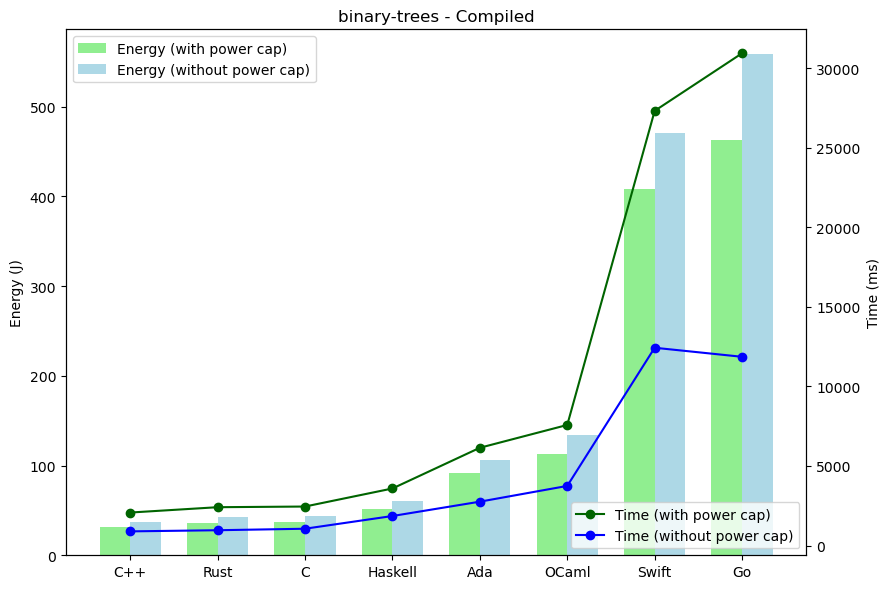

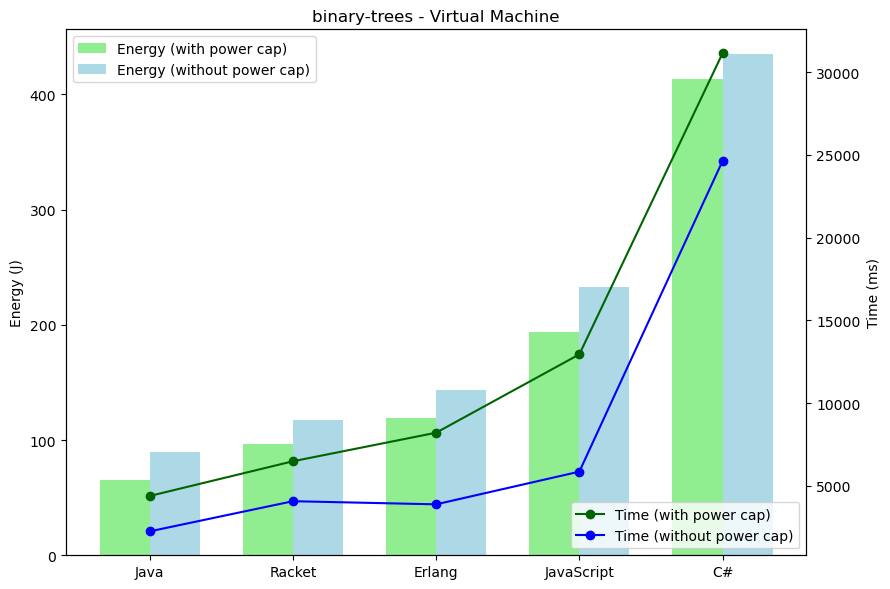

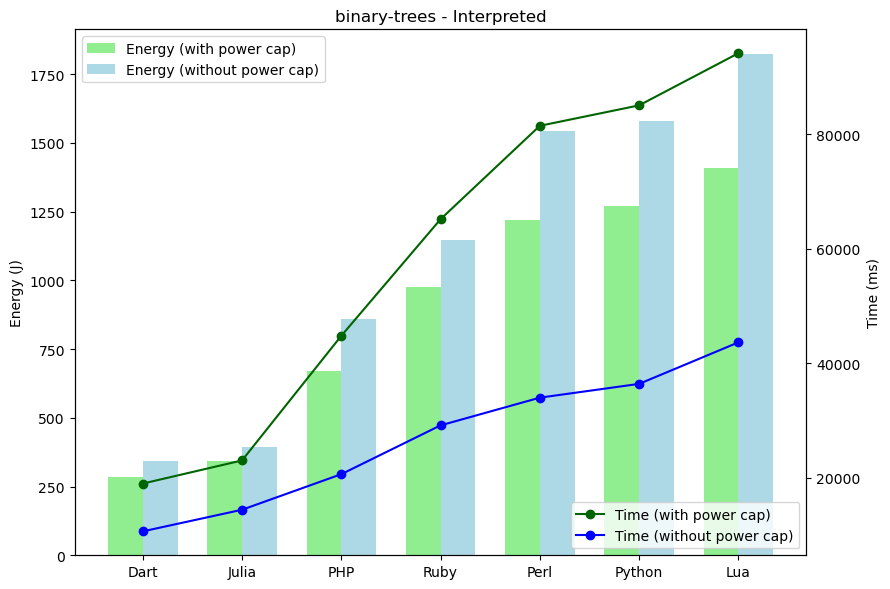

In [181]:
# Separate data by Type and PowerLimit
compiled_15_data = singleProblemDF[(singleProblemDF['Type'] == 'Compiled') & (singleProblemDF['PowerLimit'] == 15)]
compiled_minus_1_data = singleProblemDF[(singleProblemDF['Type'] == 'Compiled') & (singleProblemDF['PowerLimit'] == -1)]

vm_15_data = singleProblemDF[(singleProblemDF['Type'] == 'Virtual Machine') & (singleProblemDF['PowerLimit'] == 15)]
vm_minus_1_data = singleProblemDF[(singleProblemDF['Type'] == 'Virtual Machine') & (singleProblemDF['PowerLimit'] == -1)]

interpreted_15_data = singleProblemDF[(singleProblemDF['Type'] == 'Interpreted') & (singleProblemDF['PowerLimit'] == 15)]
interpreted_minus_1_data = singleProblemDF[(singleProblemDF['Type'] == 'Interpreted') & (singleProblemDF['PowerLimit'] == -1)]

# Function to plot data
def plot_data(energy_15, time_15, energy_minus_1, time_minus_1, label):
    fig, ax = plt.subplots(figsize=(9, 6))
    x = np.arange(len(energy_15))
    width = 0.35

    ax.bar(x - width/2, energy_15['Energy (J)'], width, color='lightgreen', label='Energy (with power cap)')
    ax.bar(x + width/2, energy_minus_1['Energy (J)'], width, color='lightblue', label='Energy (without power cap)')
    
    ax2 = ax.twinx()
    ax2.plot(x, energy_15['Time (ms)'], color='darkgreen', marker='o', label='Time (with power cap)')
    ax2.plot(x, time_minus_1['Time (ms)'], color='blue', marker='o', label='Time (without power cap)')
    
    ax.set_xticks(x)
    ax.set_xticklabels(energy_15['Language'])
    ax.set_ylabel('Energy (J)')
    ax2.set_ylabel('Time (ms)')
    ax.set_title(label)
    ax.legend(loc='upper left')
    ax2.legend(loc='lower right')  # Adjusting legend position

    plt.tight_layout()
    plt.show()

# Plotting and displaying images
plot_data(compiled_15_data, compiled_15_data, compiled_minus_1_data, compiled_minus_1_data, f'{problem} - Compiled')
plot_data(vm_15_data, vm_15_data, vm_minus_1_data, vm_minus_1_data, f'{problem} - Virtual Machine')
plot_data(interpreted_15_data, interpreted_15_data, interpreted_minus_1_data, interpreted_minus_1_data, f'{problem} - Interpreted')

In [182]:
singleProblemDF_dict = {}

# Iterate over each program, sort by 'Package', and store in the dictionary
for program, program_df in singleProblemDF.groupby('Type'):
    sorted_df = program_df.sort_values(by='Energy (J)').reset_index(drop=True)
    singleProblemDF_dict[program] = sorted_df

# Display the result (program_order_dict)
for program, sorted_df in singleProblemDF_dict.items():
    print(f"Program: {program}")
    print(sorted_df.drop(columns=['Program']))
    print("\n")

Program: Compiled
   Language  PowerLimit  Energy (J)     Time (ms)      Type
0       C++          15   31.039503   2075.428571  Compiled
1      Rust          15   36.037733   2411.000000  Compiled
2         C          15   36.662851   2452.928571  Compiled
3       C++          -1   37.163199    893.000000  Compiled
4      Rust          -1   42.265533    964.571429  Compiled
5         C          -1   43.835545   1058.785714  Compiled
6   Haskell          15   51.612270   3586.571429  Compiled
7   Haskell          -1   60.254364   1857.642857  Compiled
8       Ada          15   91.781001   6143.857143  Compiled
9       Ada          -1  105.951338   2758.571429  Compiled
10    OCaml          15  113.276838   7577.285714  Compiled
11    OCaml          -1  134.281010   3748.000000  Compiled
12    Swift          15  408.260991  27308.500000  Compiled
13       Go          15  462.370623  30927.785714  Compiled
14    Swift          -1  471.039804  12427.142857  Compiled
15       Go          -

### Final plots with energy and time sums

In [183]:
#dfSomasPrograms = dfRanking.groupby(['Language' , 'Program' ,'PowerLimit']).agg({'Energy (J)': 'mean', 'Time (ms)': 'mean'}).reset_index()
dfSomasPrograms = dfRanking.groupby(['Language' ,'PowerLimit']).agg({'Energy (J)': 'sum', 'Time (ms)': 'sum'}).reset_index()
dfSomasPrograms.head(5)

,Language,PowerLimit,Energy (J),Time (ms)
0,Ada,-1,997.213915,31113.785714
1,Ada,15,881.105059,58956.500000
2,C,-1,380.009208,11349.285714
3,C,15,330.730360,22108.428571
4,C#,-1,986.920340,42667.857143


In [184]:
dataset_power_no_limit = dfSomasPrograms[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
dataset_power_limit_15 = dfSomasPrograms[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])

/tmp/ipykernel_14111/2430238798.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_power_no_limit = dfSomasPrograms[dfRanking['PowerLimit'] == -1].drop(columns=['PowerLimit'])
/tmp/ipykernel_14111/2430238798.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_power_limit_15 = dfSomasPrograms[dfRanking['PowerLimit'] == 15].drop(columns=['PowerLimit'])


#### Final plots in terms of energy (without power cap)

In [185]:
dataset_power_no_limit = dataset_power_no_limit.sort_values(by='Energy (J)').reset_index(drop=True)
dataset_power_no_limit.head(20)

,Language,Energy (J),Time (ms)
0,C++,375.565831,1.170964e+04
1,C,380.009208,1.134929e+04
2,Rust,709.621512,2.009071e+04
3,C#,986.920340,4.266786e+04
4,Ada,997.213915,3.111379e+04
5,Java,1183.926291,3.275693e+04
6,Julia,1308.099622,6.058486e+04
7,OCaml,1534.605146,4.911057e+04
8,Go,1581.946520,4.115157e+04
9,JavaScript,1669.989323,5.085271e+04


In [186]:
# Define the reference values for Energy and Time
reference_energy = dataset_power_no_limit.loc[0, 'Energy (J)']
reference_time = dataset_power_no_limit.loc[0, 'Time (ms)']

# Normalize Energy and Time columns
dataset_power_no_limit_normalized = dataset_power_no_limit.copy()
dataset_power_no_limit_normalized['Energy Normalized'] = dataset_power_no_limit_normalized['Energy (J)'] / reference_energy
dataset_power_no_limit_normalized['Time Normalized'] = dataset_power_no_limit_normalized['Time (ms)'] / reference_time
dataset_power_no_limit_normalized = dataset_power_no_limit_normalized.drop(columns=['Energy (J)','Time (ms)'])
dataset_power_no_limit_normalized.head(20)
#TODO

,Language,Energy Normalized,Time Normalized
0,C++,1.000000,1.000000
1,C,1.011831,0.969226
2,Rust,1.889473,1.715741
3,C#,2.627823,3.643822
4,Ada,2.655231,2.657108
5,Java,3.152380,2.797432
6,Julia,3.483010,5.173929
7,OCaml,4.086115,4.194028
8,Go,4.212168,3.514332
9,JavaScript,4.446595,4.342807


#### Final plots in terms of energy (with power cap 15)

In [187]:
dataset_power_limit_15 = dataset_power_limit_15.sort_values(by='Energy (J)').reset_index(drop=True)
dataset_power_limit_15.head(20)

,Language,Energy (J),Time (ms)
0,C,330.730360,2.210843e+04
1,C++,331.092826,2.213257e+04
2,Rust,642.912035,4.298686e+04
3,Ada,881.105059,5.895650e+04
4,C#,904.564039,6.410493e+04
5,Java,1028.237470,6.878543e+04
6,Julia,1225.345947,8.199821e+04
7,OCaml,1324.824506,8.860921e+04
8,Go,1357.772239,9.081650e+04
9,JavaScript,1440.615361,9.640971e+04


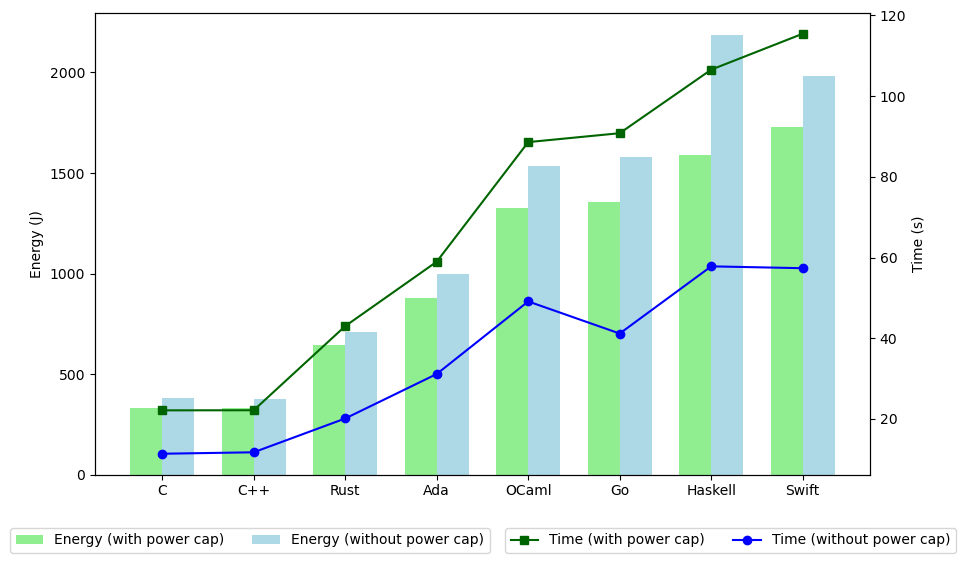

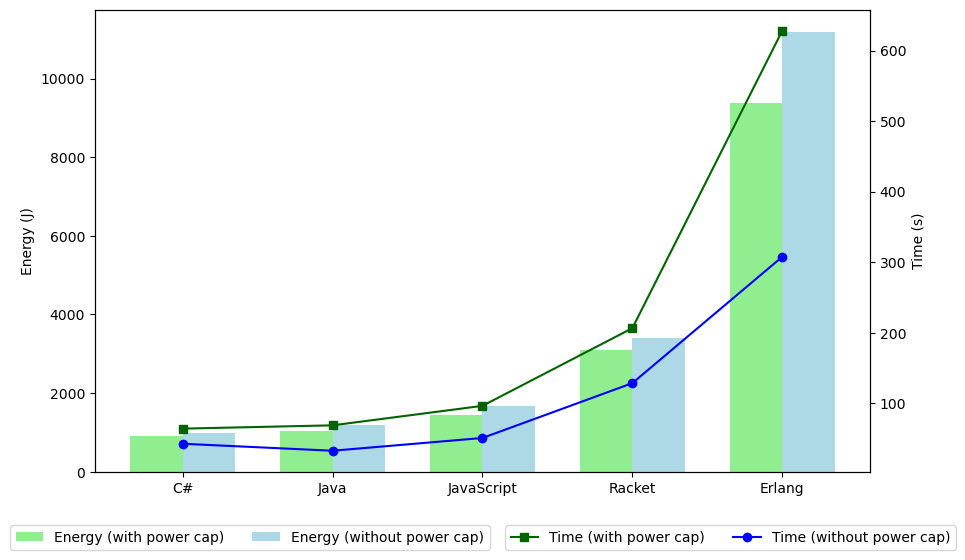

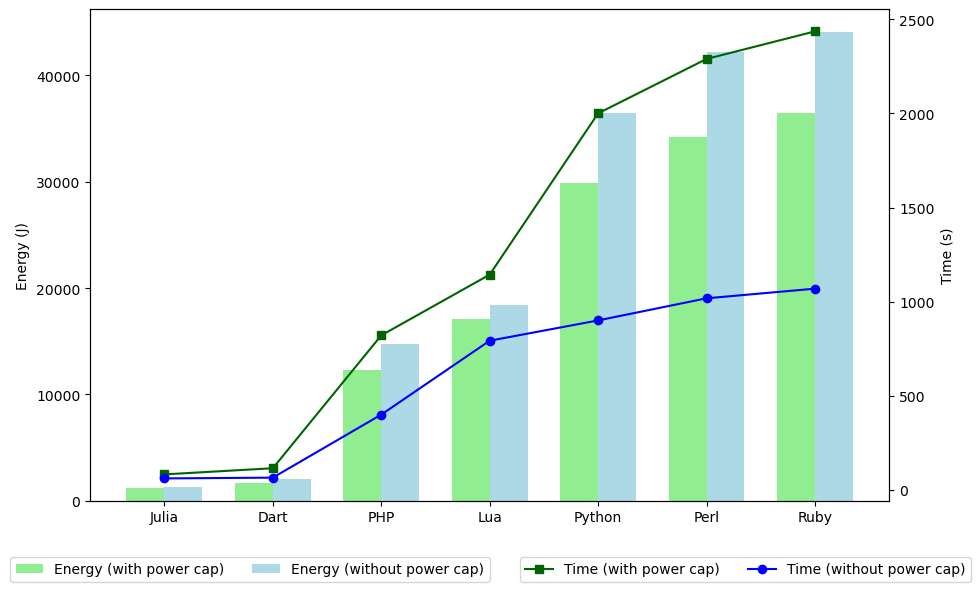

In [188]:
# Add 'Type' column and initialize with "undefined"
dataset_power_no_limit['Type'] = "undefined"
dataset_power_limit_15['Type'] = "undefined"

# Categorize languages by type
compiled_languages = ['Ada', 'C', 'C++', 'Go', 'Haskell', 'OCaml', 'Rust', 'Swift']
interpreted_languages = ['Dart', 'Lua', 'Perl', 'PHP', 'Python', 'Ruby', 'Julia']
vm_languages = ['C#', 'Erlang', 'Java', 'JavaScript', 'Racket']

dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(compiled_languages), 'Type'] = "Compiled"
dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(interpreted_languages), 'Type'] = "Interpreted"
dataset_power_no_limit.loc[dataset_power_no_limit['Language'].isin(vm_languages), 'Type'] = "Virtual Machine"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(compiled_languages), 'Type'] = "Compiled"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(interpreted_languages), 'Type'] = "Interpreted"
dataset_power_limit_15.loc[dataset_power_limit_15['Language'].isin(vm_languages), 'Type'] = "Virtual Machine"

# Create new datasets with the order of dataset_power_limit_15
dataset_power_no_limit_ordered = dataset_power_limit_15[['Language']].merge(
    dataset_power_no_limit, on='Language', how='left'
)

# Separate data by Type and PowerLimit
compiled_15_data = dataset_power_limit_15[dataset_power_limit_15['Type'] == 'Compiled']
compiled_minus_1_data = dataset_power_no_limit_ordered[dataset_power_no_limit_ordered['Type'] == 'Compiled']

vm_15_data = dataset_power_limit_15[dataset_power_limit_15['Type'] == 'Virtual Machine']
vm_minus_1_data = dataset_power_no_limit_ordered[dataset_power_no_limit_ordered['Type'] == 'Virtual Machine']

interpreted_15_data = dataset_power_limit_15[dataset_power_limit_15['Type'] == 'Interpreted']
interpreted_minus_1_data = dataset_power_no_limit_ordered[dataset_power_no_limit_ordered['Type'] == 'Interpreted']

# Function to plot data
def plot_data(ax, energy_15, time_15, energy_minus_1, time_minus_1, label):
    x = np.arange(len(energy_15))
    width = 0.35

    # Plotting the energy bars
    ax.bar(x - width / 2, energy_15['Energy (J)'], width, color='lightgreen', label='Energy (with power cap)')
    ax.bar(x + width / 2, energy_minus_1['Energy (J)'], width, color='lightblue', label='Energy (without power cap)')

    # Create a second axis for time (twinx)
    ax2 = ax.twinx()

    # Using squares ('s') for the "with power cap" and circles ('o') for the "without power cap"
    ax2.plot(x, (time_15['Time (ms)'] / 1000), color='darkgreen', marker='s', label='Time (with power cap)')
    ax2.plot(x, (time_minus_1['Time (ms)'] / 1000), color='blue', marker='o', label='Time (without power cap)')

    # Setting labels, ticks, and legends
    ax.set_xticks(x)
    ax.set_xticklabels(energy_15['Language'])
    ax.set_ylabel('Energy (J)')
    ax2.set_ylabel('Time (s)')
    # ax.set_title(label)

    # Adjust the legends to be side by side below the x-axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.2, -0.1), ncol=2)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.82, -0.1), ncol=2)

# Create three separate figures for different language types
fig1, ax1 = plt.subplots(figsize=(10, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))
fig3, ax3 = plt.subplots(figsize=(10, 6))

# Plot data for Compiled languages
plot_data(ax1, compiled_15_data, compiled_15_data, compiled_minus_1_data, compiled_minus_1_data, 'CLBG problems - Compiled')

# Plot data for Virtual Machine languages
plot_data(ax2, vm_15_data, vm_15_data, vm_minus_1_data, vm_minus_1_data, 'CLBG problems - Virtual Machine')

# Plot data for Interpreted languages
plot_data(ax3, interpreted_15_data, interpreted_15_data, interpreted_minus_1_data, interpreted_minus_1_data, 'CLBG problems - Interpreted')

# Show the plots
plt.tight_layout()
plt.show()

### Final ranking comparing energy and time with the use of power capping

In [189]:
result_df = []
#  Iterate over languages in the program
for language in dataset_power_limit_15['Language']:
    # Extract data for the specific language in both dictionaries
    row_df1 = dataset_power_limit_15[dataset_power_limit_15['Language'] == language]
    row_df2 = dataset_power_no_limit[dataset_power_no_limit['Language'] == language]

    # Calculate the differences
    position_changes = row_df1.index[0] - row_df2.index[0]
    energy_difference = row_df1['Energy (J)'].iloc[0] - row_df2['Energy (J)'].iloc[0]
    time_difference = row_df1['Time (ms)'].iloc[0] - row_df2['Time (ms)'].iloc[0]
    # Append the results to the comparison list
    result_df.append({
        'Language': language,
        'Energy (J)': row_df1['Energy (J)'].iloc[0],
        'Time (ms)': row_df1['Time (ms)'].iloc[0],
        'Position Changes': position_changes,
        'Energy Difference (J)': energy_difference,
        'Energy Difference %': energy_difference/row_df2['Energy (J)'].iloc[0]*100,
        'Time Difference (ms)': time_difference,
        'Time Difference %': time_difference/row_df2['Time (ms)'].iloc[0]*100
    })

# Convert the list of dictionaries into a DataFrame
result_df = pd.DataFrame(result_df)

# Display the comparison results
result_df.head(20)

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,330.730360,2.210843e+04,-1,-49.278848,-12.967804,1.075914e+04,94.800176
1,C++,331.092826,2.213257e+04,1,-44.473005,-11.841600,1.042293e+04,89.011498
2,Rust,642.912035,4.298686e+04,0,-66.709477,-9.400712,2.289614e+04,113.963807
3,Ada,881.105059,5.895650e+04,-1,-116.108856,-11.643325,2.784271e+04,89.486746
4,C#,904.564039,6.410493e+04,1,-82.356301,-8.344777,2.143707e+04,50.241734
5,Java,1028.237470,6.878543e+04,0,-155.688821,-13.150212,3.602850e+04,109.987418
6,Julia,1225.345947,8.199821e+04,0,-82.753675,-6.326252,2.141336e+04,35.344405
7,OCaml,1324.824506,8.860921e+04,0,-209.780640,-13.670008,3.949864e+04,80.427985
8,Go,1357.772239,9.081650e+04,0,-224.174282,-14.170788,4.966493e+04,120.687806
9,JavaScript,1440.615361,9.640971e+04,0,-229.373962,-13.735056,4.555700e+04,89.586172


In [190]:
print("Energy saving average J: " + str(result_df['Energy Difference (J)'].mean()))
print("Energy saving average %: " + str(result_df['Energy Difference %'].mean()))
print("Time difference ms: " + str(result_df['Time Difference (ms)'].mean()))
print("Time difference %: " + str(result_df['Time Difference %'].mean()))


Energy saving average J: -1525.1352103097101
Energy saving average %: -13.75379629604287
Time difference ms: 267657.1357142857
Time difference %: 91.30255463451272


In [191]:
# Define the reference values for Energy and Time
reference_energy = result_df.loc[0, 'Energy (J)']
reference_time = result_df.loc[0, 'Time (ms)']

# Normalize Energy and Time columns
result_df_normalized = result_df.copy()
result_df_normalized['Energy (J)'] = result_df_normalized['Energy (J)'] / reference_energy
result_df_normalized['Time (ms)'] = result_df_normalized['Time (ms)'] / reference_time
result_df_normalized.head(20)

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
0,C,1.000000,1.000000,-1,-49.278848,-12.967804,1.075914e+04,94.800176
1,C++,1.001096,1.001092,1,-44.473005,-11.841600,1.042293e+04,89.011498
2,Rust,1.943916,1.944365,0,-66.709477,-9.400712,2.289614e+04,113.963807
3,Ada,2.664119,2.666698,-1,-116.108856,-11.643325,2.784271e+04,89.486746
4,C#,2.735050,2.899570,1,-82.356301,-8.344777,2.143707e+04,50.241734
5,Java,3.108990,3.111276,0,-155.688821,-13.150212,3.602850e+04,109.987418
6,Julia,3.704970,3.708912,0,-82.753675,-6.326252,2.141336e+04,35.344405
7,OCaml,4.005754,4.007938,0,-209.780640,-13.670008,3.949864e+04,80.427985
8,Go,4.105375,4.107777,0,-224.174282,-14.170788,4.966493e+04,120.687806
9,JavaScript,4.355861,4.360767,0,-229.373962,-13.735056,4.555700e+04,89.586172


In [192]:
result_df = result_df.sort_values(by='Energy Difference %')
result_df.head(20)

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
10,Haskell,1590.383418,1.065689e+05,-2,-597.113974,-27.296671,4.876157e+04,84.351948
18,Perl,34232.888894,2.289864e+06,0,-7979.467255,-18.903155,1.272060e+06,124.980727
17,Python,29912.132834,2.000838e+06,0,-6562.492972,-17.991940,1.100536e+06,122.240756
19,Ruby,36424.086465,2.436441e+06,0,-7608.353228,-17.278973,1.367355e+06,127.899455
15,PHP,12271.254307,8.208522e+05,0,-2487.354017,-16.853581,4.212072e+05,105.395342
14,Erlang,9385.789437,6.282122e+05,0,-1805.443512,-16.132660,3.204828e+05,104.144341
11,Dart,1713.390939,1.146926e+05,0,-326.841854,-16.019831,4.997264e+04,77.213687
8,Go,1357.772239,9.081650e+04,0,-224.174282,-14.170788,4.966493e+04,120.687806
9,JavaScript,1440.615361,9.640971e+04,0,-229.373962,-13.735056,4.555700e+04,89.586172
7,OCaml,1324.824506,8.860921e+04,0,-209.780640,-13.670008,3.949864e+04,80.427985


In [193]:
result_df = result_df.sort_values(by='Time Difference %')
result_df.head(20)

,Language,Energy (J),Time (ms),Position Changes,Energy Difference (J),Energy Difference %,Time Difference (ms),Time Difference %
6,Julia,1225.345947,8.199821e+04,0,-82.753675,-6.326252,2.141336e+04,35.344405
16,Lua,17096.960924,1.143607e+06,0,-1297.658173,-7.054553,3.511662e+05,44.314497
4,C#,904.564039,6.410493e+04,1,-82.356301,-8.344777,2.143707e+04,50.241734
13,Racket,3087.490265,2.065559e+05,0,-323.803632,-9.492106,7.795614e+04,60.619219
11,Dart,1713.390939,1.146926e+05,0,-326.841854,-16.019831,4.997264e+04,77.213687
7,OCaml,1324.824506,8.860921e+04,0,-209.780640,-13.670008,3.949864e+04,80.427985
10,Haskell,1590.383418,1.065689e+05,-2,-597.113974,-27.296671,4.876157e+04,84.351948
1,C++,331.092826,2.213257e+04,1,-44.473005,-11.841600,1.042293e+04,89.011498
3,Ada,881.105059,5.895650e+04,-1,-116.108856,-11.643325,2.784271e+04,89.486746
9,JavaScript,1440.615361,9.640971e+04,0,-229.373962,-13.735056,4.555700e+04,89.586172


### Energy gains by language while executing the CLBG

/tmp/ipykernel_14111/148836089.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Language', y='Energy Difference %', data=result_df_sorted, palette='viridis')


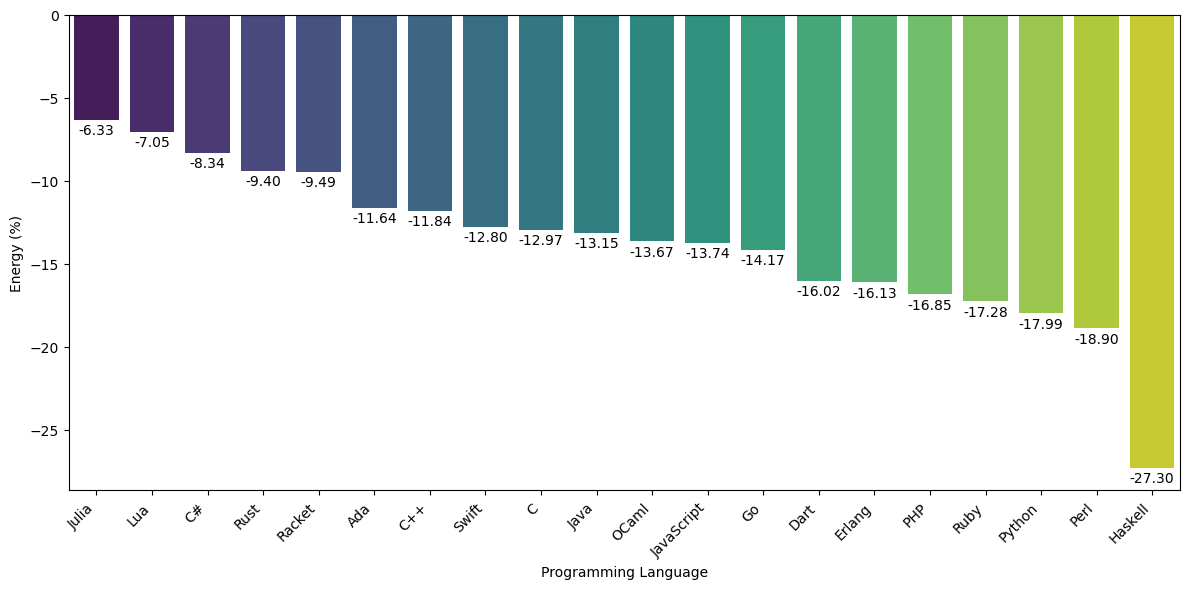

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the DataFrame by the 'Energy Difference %' column in descending order
result_df_sorted = result_df_normalized.sort_values(by='Energy Difference %', ascending=False)

# Create the barplot with the specified order
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Language', y='Energy Difference %', data=result_df_sorted, palette='viridis')

# Add labels and title
plt.xlabel('Programming Language')
plt.ylabel('Energy (%)')
# plt.title('Percentual energy difference by programming language')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add the values of the bars with rounding below the bars
for index, value in enumerate(result_df_sorted['Energy Difference %']):
    bar_plot.text(index, value - 0.2, f"{value:.2f}", ha='center', va='top', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


### Time gains by language while executing the CLBG

/tmp/ipykernel_14111/2571757139.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Language', y='Time Difference %', data=result_df_sorted, palette='viridis')


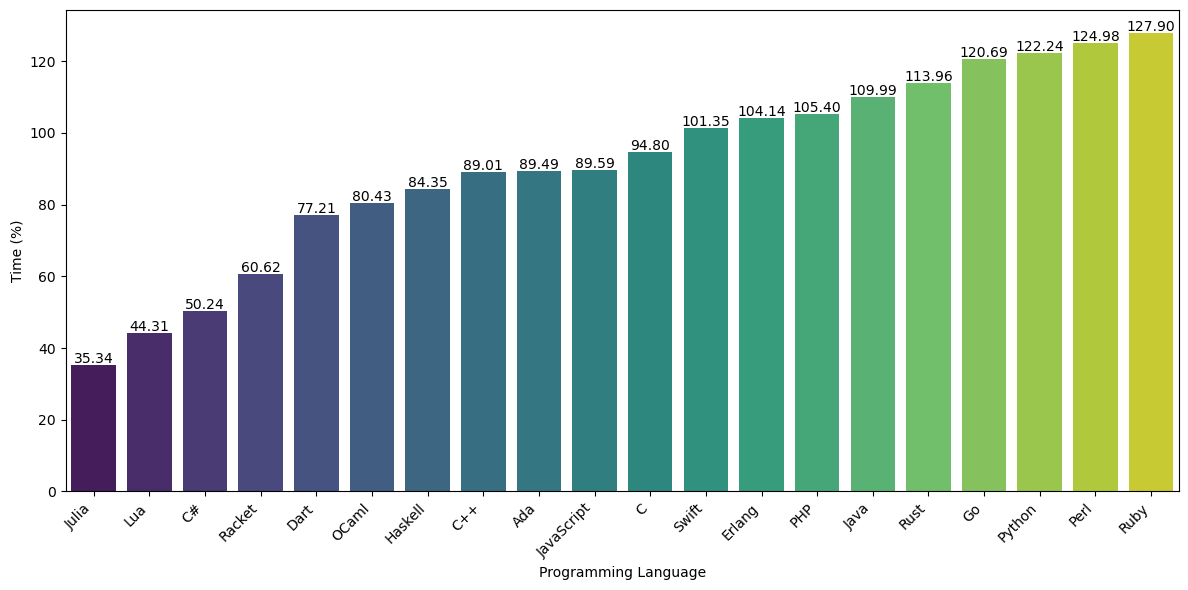

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the DataFrame by the 'Time Difference %' column in descending order
result_df_sorted = result_df_normalized.sort_values(by='Time Difference %')

# Create the barplot with the specified order
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Language', y='Time Difference %', data=result_df_sorted, palette='viridis')

# Add labels and title
plt.xlabel('Programming Language')
plt.ylabel('Time (%)')
# plt.title('Percentual energy difference by programming language')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add the values of the bars with rounding below the bars
for index, value in enumerate(result_df_sorted['Time Difference %']):
    bar_plot.text(index, value + 3.6, f"{value:.2f}", ha='center', va='top', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

### Energy and Time Statistic Tests

In [196]:
dfAnalise

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
1,Ada,binary-trees,-1,104.618347,2786.0,30.2,202912.0
4,Ada,binary-trees,-1,104.885132,2784.0,32.2,203208.0
7,Ada,binary-trees,-1,104.973206,2787.0,34.0,202772.0
11,Ada,binary-trees,-1,105.053101,2803.0,35.5,202772.0
3,Ada,binary-trees,-1,105.154663,2731.0,32.5,203136.0
...,...,...,...,...,...,...,...
20895,Swift,spectral-norm,25,41.473877,1663.0,40.0,8272.0
20897,Swift,spectral-norm,25,41.481934,1663.0,39.5,8216.0
20894,Swift,spectral-norm,25,41.497986,1663.0,39.2,8428.0
20881,Swift,spectral-norm,25,41.518494,1664.0,39.5,8272.0


#### Checking if data follows a normal distribution

#### Package

In [197]:
import pandas as pd
from scipy.stats import shapiro

# Assuming dfAnalise is already defined and contains the necessary columns
language = "Ada"

# Function to check normality and store results in a DataFrame
def test_normality_by_group(data, var_name, power_limit):
    results = {'Language': [], 'Program': [], 'Stat': [], 'P-value': [], 'Data distribution': []}
    
    for (lang, prog), group in data.groupby(['Language', 'Program']):
        subset = group[group['PowerLimit'] == power_limit][var_name]
        if len(subset) > 3:  # The Shapiro-Wilk test requires at least 3 values
            stat, p = shapiro(subset)
            distribution = "Normal" if p > 0.05 else "Not normal"
        else:
            stat, p = float('nan'), float('nan')
            distribution = "Insufficient data"
        
        results['Language'].append(lang)
        results['Program'].append(prog)
        results['Stat'].append(stat)
        results['P-value'].append(p)
        results['Data distribution'].append(distribution)
    
    df_results = pd.DataFrame(results)
    return df_results

# Check normality for "Package" with PowerLimit = -1
df_normality_package_minus_1_package = test_normality_by_group(dfAnalise, 'Package', -1)
print(f"Normality test for 'Package' with PowerLimit = -1 and for the language {language}:")
df_normality_package_minus_1_package[df_normality_package_minus_1_package["Language"] == language]


Normality test for 'Package' with PowerLimit = -1 and for the language Ada:


,Language,Program,Stat,P-value,Data distribution
0,Ada,binary-trees,0.943456,0.464380,Normal
1,Ada,fannkuch-redux,0.890457,0.082068,Normal
2,Ada,fasta,0.954175,0.627186,Normal
3,Ada,k-nucleotide,0.693966,0.000320,Not normal
4,Ada,mandelbrot,0.901095,0.116987,Normal
5,Ada,n-body,0.787062,0.003468,Not normal
6,Ada,regex-redux,0.970873,0.888122,Normal
7,Ada,reverse-complement,0.915454,0.189062,Normal
8,Ada,spectral-norm,0.951971,0.591712,Normal


In [198]:
# Check normality for "Package" with PowerLimit = 15
df_normality_package_15_package = test_normality_by_group(dfAnalise, 'Package', 15)
print(f"Normality test for 'Package' with PowerLimit = 15 and for the language {language}:")
df_normality_package_15_package[df_normality_package_15_package["Language"] == language]


Normality test for 'Package' with PowerLimit = 15 and for the language Ada:


,Language,Program,Stat,P-value,Data distribution
0,Ada,binary-trees,0.805227,0.005796,Not normal
1,Ada,fannkuch-redux,0.839490,0.016040,Not normal
2,Ada,fasta,0.917334,0.201275,Normal
3,Ada,k-nucleotide,0.811044,0.006858,Not normal
4,Ada,mandelbrot,0.919163,0.213881,Normal
5,Ada,n-body,0.668853,0.000179,Not normal
6,Ada,regex-redux,0.947227,0.518546,Normal
7,Ada,reverse-complement,0.898774,0.108258,Normal
8,Ada,spectral-norm,0.917018,0.199168,Normal


#### Time

In [199]:
import pandas as pd
from scipy.stats import shapiro

# Assuming dfAnalise is already defined and contains the necessary columns
language = "Ada"

# Function to check normality and store results in a DataFrame
def test_normality_by_group(data, var_name, power_limit):
    results = {'Language': [], 'Program': [], 'Stat': [], 'P-value': [], 'Data distribution': []}
    
    for (lang, prog), group in data.groupby(['Language', 'Program']):
        subset = group[group['PowerLimit'] == power_limit][var_name]
        if len(subset) > 3:  # The Shapiro-Wilk test requires at least 3 values
            stat, p = shapiro(subset)
            distribution = "Normal" if p > 0.05 else "Not normal"
        else:
            stat, p = float('nan'), float('nan')
            distribution = "Insufficient data"
        
        results['Language'].append(lang)
        results['Program'].append(prog)
        results['Stat'].append(stat)
        results['P-value'].append(p)
        results['Data distribution'].append(distribution)
    
    df_results = pd.DataFrame(results)
    return df_results

# Check normality for "Time" with PowerLimit = -1
df_normality_package_minus_1_time = test_normality_by_group(dfAnalise, 'Time', -1)
print(f"Normality test for 'Time' with PowerLimit = -1 and for the language {language}:")
df_normality_package_minus_1_time[df_normality_package_minus_1_time["Language"] == language]


Normality test for 'Time' with PowerLimit = -1 and for the language Ada:


/home/spidey/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,Language,Program,Stat,P-value,Data distribution
0,Ada,binary-trees,0.903493,0.126757,Normal
1,Ada,fannkuch-redux,0.871120,0.043509,Not normal
2,Ada,fasta,0.911932,0.168101,Normal
3,Ada,k-nucleotide,0.751235,0.001323,Not normal
4,Ada,mandelbrot,0.963699,0.783215,Normal
5,Ada,n-body,0.611703,0.000052,Not normal
6,Ada,regex-redux,0.925144,0.260530,Normal
7,Ada,reverse-complement,0.678884,0.000225,Not normal
8,Ada,spectral-norm,0.508217,0.000007,Not normal


In [200]:
# Check normality for "Time" with PowerLimit = 15
df_normality_package_15_time = test_normality_by_group(dfAnalise, 'Time', 15)
print(f"Normality test for 'Time' with PowerLimit = 15 and for the language {language}:")
df_normality_package_15_time[df_normality_package_15_time["Language"] == language]


Normality test for 'Time' with PowerLimit = 15 and for the language Ada:


,Language,Program,Stat,P-value,Data distribution
0,Ada,binary-trees,0.815406,0.007789,Not normal
1,Ada,fannkuch-redux,0.840763,0.016679,Not normal
2,Ada,fasta,0.937010,0.381349,Normal
3,Ada,k-nucleotide,0.808878,0.006440,Not normal
4,Ada,mandelbrot,0.854430,0.025523,Not normal
5,Ada,n-body,0.664533,0.000162,Not normal
6,Ada,regex-redux,0.937644,0.388967,Normal
7,Ada,reverse-complement,0.929310,0.298416,Normal
8,Ada,spectral-norm,0.957063,0.674567,Normal


#### Analysing the number of samples that follows normal distribution

In [201]:
cv1_p = df_normality_package_minus_1_package['Data distribution'].value_counts()
cv2_p = df_normality_package_15_package['Data distribution'].value_counts()

print("-----------------Package-----------------")
print("Power cap -1:")
print(cv1_p)
print()
print("Power cap 15:")
print(cv2_p)


cv1_t = df_normality_package_minus_1_time['Data distribution'].value_counts()
cv2_t = df_normality_package_15_time['Data distribution'].value_counts()

print("\n\n-----------------Time-----------------")

print("Power cap -1:")
print(cv1_t)
print()
print("Power cap 15:")
print(cv2_t)

-----------------Package-----------------
Power cap -1:
Data distribution
Normal        130
Not normal     50
Name: count, dtype: int64

Power cap 15:
Data distribution
Normal        119
Not normal     61
Name: count, dtype: int64


-----------------Time-----------------
Power cap -1:
Data distribution
Normal        96
Not normal    84
Name: count, dtype: int64

Power cap 15:
Data distribution
Normal        116
Not normal     64
Name: count, dtype: int64


#### Saving QQ-Plots to analyse the data distribution of each sample Language-Program

##### Energy (without powercap)

In [202]:
# Not Normal Distribution
not_normal_programs = df_normality_package_minus_1_package[df_normality_package_minus_1_package['Data distribution'] == 'Not normal']
not_normal_combinations = not_normal_programs[['Language', 'Program']].drop_duplicates() # NOTE: Did not remove any program
not_normal_df_energy_1 = dfAnalise[
    (dfAnalise['PowerLimit'] == -1) &
    dfAnalise[['Language', 'Program']].apply(tuple, axis=1).isin(not_normal_combinations.apply(tuple, axis=1))
]
not_normal_df_energy_1

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
67,Ada,k-nucleotide,-1,150.210815,5516.0,37.2,259156.0
63,Ada,k-nucleotide,-1,150.224609,5529.0,36.5,259236.0
75,Ada,k-nucleotide,-1,150.428467,5460.0,37.5,259176.0
62,Ada,k-nucleotide,-1,150.536194,5512.0,35.8,258848.0
64,Ada,k-nucleotide,-1,150.572754,5514.0,37.2,258956.0
...,...,...,...,...,...,...,...
4131,Swift,regex-redux,-1,452.464539,15585.0,40.0,1027988.0
4128,Swift,regex-redux,-1,452.764404,15588.0,38.5,1032104.0
4132,Swift,regex-redux,-1,454.412415,15609.0,41.2,1028140.0
4121,Swift,regex-redux,-1,456.612488,15627.0,38.8,1033324.0


In [203]:
# Normal Distribution
normal_programs = df_normality_package_minus_1_package[df_normality_package_minus_1_package['Data distribution'] == 'Normal']
normal_combinations = normal_programs[['Language', 'Program']].drop_duplicates() # NOTE: Did not remove any program
normal_df_energy_1 = dfAnalise[
    (dfAnalise['PowerLimit'] == -1) &
    dfAnalise[['Language', 'Program']].apply(tuple, axis=1).isin(normal_combinations.apply(tuple, axis=1))
]
normal_df_energy_1

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
1,Ada,binary-trees,-1,104.618347,2786.0,30.2,202912.0
4,Ada,binary-trees,-1,104.885132,2784.0,32.2,203208.0
7,Ada,binary-trees,-1,104.973206,2787.0,34.0,202772.0
11,Ada,binary-trees,-1,105.053101,2803.0,35.5,202772.0
3,Ada,binary-trees,-1,105.154663,2731.0,32.5,203136.0
...,...,...,...,...,...,...,...
4178,Swift,spectral-norm,-1,43.504639,1337.0,40.8,8112.0
4164,Swift,spectral-norm,-1,43.506287,1336.0,40.5,8344.0
4179,Swift,spectral-norm,-1,43.518372,1336.0,41.0,8176.0
4163,Swift,spectral-norm,-1,43.544373,1339.0,40.5,8280.0


##### Energy (with powercap = 15)

In [204]:
# Not Normal Distribution
not_normal_programs = df_normality_package_15_package[df_normality_package_15_package['Data distribution'] == 'Not normal']
not_normal_combinations = not_normal_programs[['Language', 'Program']].drop_duplicates() # NOTE: Did not remove any program
not_normal_df_energy_15 = dfAnalise[
    (dfAnalise['PowerLimit'] == 15) &
    dfAnalise[['Language', 'Program']].apply(tuple, axis=1).isin(not_normal_combinations.apply(tuple, axis=1))
]
not_normal_df_energy_15

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
12541,Ada,binary-trees,15,90.513672,6059.0,33.2,203232.0
12540,Ada,binary-trees,15,90.765747,6075.0,33.0,203184.0
12550,Ada,binary-trees,15,90.942749,6088.0,34.2,202828.0
12542,Ada,binary-trees,15,90.996826,6090.0,32.8,202828.0
12557,Ada,binary-trees,15,91.107971,6096.0,35.2,202812.0
...,...,...,...,...,...,...,...
16664,Swift,regex-redux,15,414.969482,27758.0,37.2,1035320.0
16670,Swift,regex-redux,15,415.642212,27807.0,36.0,1033952.0
16672,Swift,regex-redux,15,415.730164,27808.0,36.8,1023380.0
16678,Swift,regex-redux,15,415.741516,27809.0,36.5,1014456.0


In [205]:
# Normal Distribution
normal_programs = df_normality_package_15_package[df_normality_package_15_package['Data distribution'] == 'Normal']
normal_combinations = normal_programs[['Language', 'Program']].drop_duplicates() # NOTE: Did not remove any program
normal_df_energy_15 = dfAnalise[
    (dfAnalise['PowerLimit'] == 15) &
    dfAnalise[['Language', 'Program']].apply(tuple, axis=1).isin(normal_combinations.apply(tuple, axis=1))
]
normal_df_energy_15

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
12589,Ada,fasta,15,44.690369,2987.0,34.5,4392.0
12594,Ada,fasta,15,44.703186,2988.0,34.8,4044.0
12597,Ada,fasta,15,44.705872,2988.0,34.8,4144.0
12584,Ada,fasta,15,44.716492,2991.0,35.2,4052.0
12590,Ada,fasta,15,44.752563,2994.0,34.8,4076.0
...,...,...,...,...,...,...,...
16700,Swift,spectral-norm,15,40.525513,2705.0,35.8,8264.0
16704,Swift,spectral-norm,15,40.529968,2705.0,36.5,8172.0
16706,Swift,spectral-norm,15,40.530701,2705.0,36.2,8104.0
16707,Swift,spectral-norm,15,40.569458,2708.0,35.5,8144.0


#### Time (without powercap)

In [206]:
# Not Normal Distribution
not_normal_programs = df_normality_package_minus_1_time[df_normality_package_minus_1_time['Data distribution'] == 'Not normal']
not_normal_combinations = not_normal_programs[['Language', 'Program']].drop_duplicates() # NOTE: Did not remove any program
not_normal_df_time_1 = dfAnalise[
    (dfAnalise['PowerLimit'] == -1) &
    dfAnalise[['Language', 'Program']].apply(tuple, axis=1).isin(not_normal_combinations.apply(tuple, axis=1))
]
not_normal_df_time_1

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
22,Ada,fannkuch-redux,-1,289.849731,6776.0,42.0,5124.0
23,Ada,fannkuch-redux,-1,289.993774,6749.0,41.0,5024.0
24,Ada,fannkuch-redux,-1,290.264404,6740.0,41.5,4892.0
26,Ada,fannkuch-redux,-1,290.344360,6734.0,41.5,5084.0
29,Ada,fannkuch-redux,-1,290.362366,6722.0,41.0,4984.0
...,...,...,...,...,...,...,...
4178,Swift,spectral-norm,-1,43.504639,1337.0,40.8,8112.0
4164,Swift,spectral-norm,-1,43.506287,1336.0,40.5,8344.0
4179,Swift,spectral-norm,-1,43.518372,1336.0,41.0,8176.0
4163,Swift,spectral-norm,-1,43.544373,1339.0,40.5,8280.0


In [207]:
# Normal Distribution
normal_programs = df_normality_package_minus_1_time[df_normality_package_minus_1_time['Data distribution'] == 'Normal']
normal_combinations = normal_programs[['Language', 'Program']].drop_duplicates() # NOTE: Did not remove any program
normal_df_time_1 = dfAnalise[
    (dfAnalise['PowerLimit'] == -1) &
    dfAnalise[['Language', 'Program']].apply(tuple, axis=1).isin(normal_combinations.apply(tuple, axis=1))
]
normal_df_time_1

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
1,Ada,binary-trees,-1,104.618347,2786.0,30.2,202912.0
4,Ada,binary-trees,-1,104.885132,2784.0,32.2,203208.0
7,Ada,binary-trees,-1,104.973206,2787.0,34.0,202772.0
11,Ada,binary-trees,-1,105.053101,2803.0,35.5,202772.0
3,Ada,binary-trees,-1,105.154663,2731.0,32.5,203136.0
...,...,...,...,...,...,...,...
4146,Swift,reverse-complement,-1,9.235840,416.0,34.5,287776.0
4156,Swift,reverse-complement,-1,9.238220,418.0,34.5,287808.0
4143,Swift,reverse-complement,-1,9.240356,418.0,34.8,287936.0
4141,Swift,reverse-complement,-1,9.247192,413.0,34.8,287836.0


#### Time (with powercap = 15)

In [208]:
#Not normal distribution
not_normal_programs = df_normality_package_15_time[df_normality_package_15_time['Data distribution'] == 'Not normal']
not_normal_combinations = not_normal_programs[['Language', 'Program']].drop_duplicates() # NOTE: Did not remove any program
not_normal_df_time_15 = dfAnalise[
    (dfAnalise['PowerLimit'] == 15) &
    dfAnalise[['Language', 'Program']].apply(tuple, axis=1).isin(not_normal_combinations.apply(tuple, axis=1))
]
not_normal_df_time_15

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
12541,Ada,binary-trees,15,90.513672,6059.0,33.2,203232.0
12540,Ada,binary-trees,15,90.765747,6075.0,33.0,203184.0
12550,Ada,binary-trees,15,90.942749,6088.0,34.2,202828.0
12542,Ada,binary-trees,15,90.996826,6090.0,32.8,202828.0
12557,Ada,binary-trees,15,91.107971,6096.0,35.2,202812.0
...,...,...,...,...,...,...,...
16664,Swift,regex-redux,15,414.969482,27758.0,37.2,1035320.0
16670,Swift,regex-redux,15,415.642212,27807.0,36.0,1033952.0
16672,Swift,regex-redux,15,415.730164,27808.0,36.8,1023380.0
16678,Swift,regex-redux,15,415.741516,27809.0,36.5,1014456.0


In [209]:
#Normal distribution
normal_programs = df_normality_package_15_time[df_normality_package_15_time['Data distribution'] == 'Normal']
normal_combinations = normal_programs[['Language', 'Program']].drop_duplicates() # NOTE: Did not remove any program
normal_df_time_15 = dfAnalise[
    (dfAnalise['PowerLimit'] == 15) &
    dfAnalise[['Language', 'Program']].apply(tuple, axis=1).isin(normal_combinations.apply(tuple, axis=1))
]
normal_df_time_15

,Language,Program,PowerLimit,Package,Time,Temperature,Memory
12589,Ada,fasta,15,44.690369,2987.0,34.5,4392.0
12594,Ada,fasta,15,44.703186,2988.0,34.8,4044.0
12597,Ada,fasta,15,44.705872,2988.0,34.8,4144.0
12584,Ada,fasta,15,44.716492,2991.0,35.2,4052.0
12590,Ada,fasta,15,44.752563,2994.0,34.8,4076.0
...,...,...,...,...,...,...,...
16700,Swift,spectral-norm,15,40.525513,2705.0,35.8,8264.0
16704,Swift,spectral-norm,15,40.529968,2705.0,36.5,8172.0
16706,Swift,spectral-norm,15,40.530701,2705.0,36.2,8104.0
16707,Swift,spectral-norm,15,40.569458,2708.0,35.5,8144.0


#### Saving QQ-plots in a specific folder structure

In [210]:
generating_qq_plots = False

if generating_qq_plots == True:
    import os
    import matplotlib.pyplot as plt
    import scipy.stats as stats

    def create_qq_plots(df, normality_tag, metric, powercap_value):
        base_dir = "qq-plots"
        os.makedirs(base_dir, exist_ok=True)

        for language in df["Language"].unique():
            language_path = os.path.join(base_dir, language, normality_tag)
            os.makedirs(language_path, exist_ok=True)

            for program in df["Program"].unique():
                # Filter data for current language and program
                subset_df = df[(df["Language"] == language) & (df["Program"] == program)]

                if not subset_df.empty:
                    program_path = os.path.join(language_path, program)
                    os.makedirs(program_path, exist_ok=True)

                    # Generate QQ-plots for each numeric column
                    for column in [metric]:
                        plt.figure()
                        stats.probplot(subset_df[column], dist="norm", plot=plt)
                        plt.title(f'QQ-Plot for {language} - {program} - {column} - PowerLimit = {powercap_value}')
                        plt.xlabel('Theoretical Quantiles')
                        plt.ylabel('Sample Quantiles')
                        plot_path = os.path.join(program_path, f'{column}_powercap={powercap_value}.png')
                        plt.savefig(plot_path)
                        plt.close()

    # Call the function to create QQ-plots
    create_qq_plots(not_normal_df_energy_1, "Not normal", "Package", "-1")
    create_qq_plots(normal_df_energy_1, "Normal", "Package", "-1")

    create_qq_plots(not_normal_df_energy_15, "Not normal", "Package", "15")
    create_qq_plots(normal_df_energy_15, "Normal", "Package", "15")

    create_qq_plots(not_normal_df_time_1, "Not normal", "Time", "-1")
    create_qq_plots(normal_df_time_1, "Normal", "Time", "-1")

    create_qq_plots(not_normal_df_time_15, "Not normal", "Time", "15")
    create_qq_plots(normal_df_time_15, "Normal", "Time", "15")


#### Statistical test

In [211]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon, shapiro

# Function to perform paired statistical test and store results in a DataFrame
def test_statistical_paired(data, var_name):
    results = {'Language': [], 'Program': [], 'Test': [], 'Stat': [], 'P-value': []}
    
    # Filter only the groups where PowerLimit = -1 and PowerLimit = 15
    data_filtered = data[data['PowerLimit'].isin([-1, 15])]
    
    for (lang, prog), group in data_filtered.groupby(['Language', 'Program']):
        group_minus_1 = group[group['PowerLimit'] == -1][var_name]
        group_15 = group[group['PowerLimit'] == 15][var_name]
        
        if len(group_minus_1) > 1 and len(group_15) > 1:
            # Check the normality of the differences
            differences = group_15.values - group_minus_1.values
            stat_shapiro, p_shapiro = shapiro(differences)
            
            if p_shapiro > 0.05:  # If the differences follow a normal distribution
                stat, p = ttest_rel(group_minus_1, group_15)
                test_name = 't-test'
            else:  # If the differences do not follow a normal distribution
                stat, p = wilcoxon(group_minus_1, group_15)
                test_name = 'wilcoxon'
        else:
            stat, p = float('nan'), float('nan')
            test_name = 'N/A'
        
        results['Language'].append(lang)
        results['Program'].append(prog)
        results['Test'].append(test_name)
        results['Stat'].append(stat)
        results['P-value'].append(p)
    
    df_results = pd.DataFrame(results)
    return df_results

# Perform paired statistical test for Package
df_stat_package = test_statistical_paired(dfAnalise, 'Package')

alpha = 0.05
df_stat_package['Is there a statistical difference?'] = df_stat_package['P-value'] < alpha

print("Paired statistical test for Package:")
df_stat_package[df_stat_package["Language"] == language]


Paired statistical test for Package:


,Language,Program,Test,Stat,P-value,Is there a statistical difference?
0,Ada,binary-trees,t-test,99.727488,3.883484e-20,True
1,Ada,fannkuch-redux,wilcoxon,0.000000,1.220703e-04,True
2,Ada,fasta,t-test,37.882759,1.080825e-14,True
3,Ada,k-nucleotide,t-test,36.960072,1.485163e-14,True
4,Ada,mandelbrot,t-test,1074.530187,1.483832e-33,True
5,Ada,n-body,wilcoxon,0.000000,1.220703e-04,True
6,Ada,regex-redux,t-test,198.144112,5.195520e-24,True
7,Ada,reverse-complement,wilcoxon,0.000000,1.220703e-04,True
8,Ada,spectral-norm,t-test,529.150420,1.481171e-29,True


In [212]:
# Perform paired t-test for Time
df_stat_time = test_statistical_paired(dfAnalise, 'Time')

alpha = 0.05
df_stat_time['Is there a statistical difference?'] = df_stat_time['P-value'] < alpha

print("Paired t-test for Time:")
df_stat_time[df_stat_time["Language"] == language]


Paired t-test for Time:


,Language,Program,Test,Stat,P-value,Is there a statistical difference?
0,Ada,binary-trees,t-test,-132.736476,9.471954e-22,True
1,Ada,fannkuch-redux,t-test,-322.195612,9.362062e-27,True
2,Ada,fasta,t-test,-362.449431,2.026653e-27,True
3,Ada,k-nucleotide,wilcoxon,0.000000,1.220703e-04,True
4,Ada,mandelbrot,t-test,-1118.107353,8.850007e-34,True
5,Ada,n-body,wilcoxon,0.000000,1.220703e-04,True
6,Ada,regex-redux,t-test,-934.712324,9.086649e-33,True
7,Ada,reverse-complement,t-test,-249.975534,2.535367e-25,True
8,Ada,spectral-norm,t-test,-435.097868,1.885581e-28,True


In [213]:
value_counts_package = df_stat_package['Is there a statistical difference?'].value_counts()
value_counts_time = df_stat_time['Is there a statistical difference?'].value_counts()

print("PACKAGE:")
print(value_counts_package)
print()
print("TIME:")
print(value_counts_time)


PACKAGE:
Is there a statistical difference?
True    180
Name: count, dtype: int64

TIME:
Is there a statistical difference?
True    180
Name: count, dtype: int64


## Storing values

In [214]:
# Categorize languages by type
benchmarkLanguages = ['Haskell', 'Python', 'Java']

filtered_no_limit = dataset_power_no_limit[dataset_power_no_limit['Language'].isin(benchmarkLanguages)].drop(columns=['Type'])
filtered_power_limit_15 = dataset_power_limit_15[dataset_power_limit_15['Language'].isin(benchmarkLanguages)].drop(columns=['Type'])

# Add a new column to distinguish between the two datasets
filtered_no_limit['Limit'] = '-1'
filtered_power_limit_15['Limit'] = '15'

# Concatenate the two filtered datasets
combined_df = pd.concat([filtered_no_limit, filtered_power_limit_15])

# Pivot the data to have "No Limit" and "Limit 15" as columns and "Energy" and "Time" as rows
pivoted_energy = combined_df.pivot_table(index='Language', columns='Limit', values='Energy (J)')
pivoted_time = combined_df.pivot_table(index='Language', columns='Limit', values='Time (ms)')

# Calculate the percentual difference between the two limits for Energy and Time
pivoted_energy['Percentual Difference'] = (pivoted_energy['15'] - pivoted_energy['-1']) / pivoted_energy['-1'] * 100
pivoted_time['Percentual Difference'] = (pivoted_time['15'] - pivoted_time['-1']) / pivoted_time['-1'] * 100

# Now, pivoted_energy and pivoted_time will only store the percentual differences
pivoted_energy = pivoted_energy[['Percentual Difference']]
pivoted_time = pivoted_time[['Percentual Difference']]

# Optionally, rename columns to make it more readable
pivoted_energy.rename(columns={'Percentual Difference': 'Energy Difference (%)'}, inplace=True)
pivoted_time.rename(columns={'Percentual Difference': 'Time Difference (%)'}, inplace=True)

# Display the final dataframes
energy_gains_clbg = pivoted_energy
time_gains_clbg = pivoted_time
%store energy_gains_clbg
%store time_gains_clbg

Stored 'energy_gains_clbg' (DataFrame)
Stored 'time_gains_clbg' (DataFrame)
